In [81]:
import requests
import json
import chardet
import re
import pandas as pd
import numpy as np
from pprint import pprint
import requests
from bixin import predict
import snownlp
import dm_pb2 as Danmaku


In [82]:
# 1.根据bvid请求得到cid
bvid = "BV12h4y1n7tt"
def get_cid():
    url = 'https://api.bilibili.com/x/player/pagelist?bvid=BV12h4y1n7tt'
    res = requests.get(url).text
    json_dict = json.loads(res)
    pprint(json_dict)
    return (json_dict["data"][0]["duration"], json_dict["data"][0]["cid"])
(max_time, cid) = get_cid()
max_time = max_time * 1000

print(cid)



{'code': 0,
 'data': [{'cid': 1114453592,
           'dimension': {'height': 1080, 'rotate': 0, 'width': 1920},
           'duration': 614,
           'first_frame': 'http://i2.hdslb.com/bfs/storyff/n230501qnc8daf9gicsjl29d4k1g63a6_firsti.jpg',
           'from': 'vupload',
           'page': 1,
           'part': '【老番茄】我求婚啦！！',
           'vid': '',
           'weblink': ''}],
 'message': '0',
 'ttl': 1}
1114453592


In [83]:
# 更新：新版api需要使用proto获取弹幕文件
def get_prot_dm(cid):
    url = 'https://api.bilibili.com/x/v2/dm/web/seg.so'
    params = {
        'type': 1,         # 弹幕类型
        'oid': cid,    # cid
        'segment_index': 1 # 弹幕分段
    }
    resp = requests.get(url, params)
    data = resp.content

    danmaku_seg = Danmaku.DmSegMobileReply()
    danmaku_seg.ParseFromString(data)

    return danmaku_seg.elems

danmu_proto = get_prot_dm(cid)

In [84]:
#得到弹幕 array
def to_list(prot):
    l = []
    for i in range(len(prot)):
        l.append({})
        l[i]["id"] = prot[i].id
        l[i]["progress"] = prot[i].progress
        l[i]["content"] = prot[i].content

    return l
listed_danmu = to_list(danmu_proto)
df = pd.DataFrame(listed_danmu)
mask = df['content'].str.len() > 10
df = df[~mask]
df['content'] = df['content'].str.replace('[^\w\s]', '')
mask = df['content'].str.len() < 1
df = df[~mask]
df.dropna(subset=['content'], inplace=True)
mask = df['content'].str.len() == 0
df = df[~mask]
print(df)

                        id  progress    content
0      1307858035565409024      1579  就知道你小子该发了
1      1307858113713882368      7848        随份子
2      1307858142964573952     18385      终于等到啦
3      1307858163198281984      4099        来早了
4      1307858254994343680     22888    来早了哈哈哈哈
...                    ...       ...        ...
10323  1310339481290872576    132927    随个三连加俩币
10324  1310342496433378304     22659    两个币随个份了
10327  1310349506801667584    287272    投两个币随份子
10328  1310349644416498688    177779  为什么没有小潮院长
10329  1308237348873509120     70350         加一

[7635 rows x 3 columns]


In [85]:
#divide into 6 parts according to time variation
def classify_sentiment(s):
    if(s<0.166):
        return 0
    if(s<0.333):
        return 1
    if(s<0.5):
        return 2
    if(s<0.666):
        return 3
    if(s<0.833):
        return 4
    if(s<=1):
        return 5
def get_sentiment(text):
    s = snownlp.SnowNLP(text)
    return classify_sentiment(s.sentiments)
index = 0
for i in range(6):
    start_time = max_time * i / 6
    end_time = max_time * (i+1) / 6
    tmp = df[(df['progress'] >= start_time) & (df['progress'] <= end_time)]
    tmp = tmp['content'].value_counts()
    tmp = pd.DataFrame({'content': tmp.index, 'count': tmp.values})
    mask = tmp['count'].values <= 3
    tmp = tmp[~mask]
    print(tmp)
    tmp['emo'] = tmp['content'].apply(get_sentiment)
    tmp.to_csv("video_"+str(index)+".csv")
    index+=1

df.to_csv("video.csv")
counts = df['content'].value_counts()


     content  count
0       新婚快乐    164
1        我生日     64
2      三连随份子     55
3        你小子     52
4        随份子     48
..       ...    ...
79     三连份子钱      4
80    新婚快乐切切      4
81  新人up请多指教      4
82      币比赞多      4
83      哈哈哈哈      4

[84 rows x 2 columns]
    content  count
0         猴    204
1      知名酒鬼    138
2   紧张是你的武器    114
3        货色     57
4    知名穿搭博主     40
..      ...    ...
68       祝福      4
69      你小子      4
70      哈哈哈      4
71      猴        4
72   两个币随份子      4

[73 rows x 2 columns]
       content  count
0         自夸小队     90
1          泰裤辣     84
2          哪位爷     41
3            猴     34
4         正片开始     34
5           翠花     31
6      紧张是你的武器     28
7         因为爱情     26
8          因为爱     24
9         社交恐惧     23
10      社交恐怖分子     19
11        全体起立     16
12          好帅     16
13         爷青回     15
14      啊啊啊啊啊啊     13
15           帅     13
16    啊啊啊啊啊啊啊啊     12
17         花少北     12
18          社恐     12
19   啊啊啊啊啊啊啊啊啊     10
20     他好帅他好帅啊     10
21

In [86]:
# 2.根据cid请求弹幕，解析弹幕得到最终的数据

# def get_data(cid):
#     final_url = "https://api.bilibili.com/x/v1/dm/list.so?oid=" + str(cid)
#     final_res = requests.get(final_url)
#     final_res.encoding = chardet.detect(final_res.content)['encoding']
#     final_res = final_res.text
#     pattern = re.compile('<d.*?>(.*?)</d>')
#     match = re.compile(r'<d\s+[^>]*\bp="([^"]*)"')
#     pa = match.findall(final_res)
#
#     data = pattern.findall(final_res)
#     danmu_time = [float(item.split(',')[0]) for item in pa]
#     danmu_mode = [float(item.split(',')[1]) for item in pa]
#     danmu_size = [float(item.split(',')[2]) for item in pa]
#     danmu_color = [float(item.split(',')[3]) for item in pa]
#     danmu_abstime = [float(item.split(',')[4]) for item in pa]
#     danmu_pool = [float(item.split(',')[5]) for item in pa]
#     danmu_id = [(item.split(',')[6]) for item in pa]
#     danmu_rowid = [float(item.split(',')[7]) for item in pa]
#     print(len(data))
#     return (data, danmu_time, danmu_mode, danmu_size, danmu_color, danmu_abstime, danmu_pool, danmu_id, danmu_rowid)
#
#
# (danmu_text, danmu_time, danmu_mode, danmu_size, danmu_color, danmu_abstime, danmu_pool, danmu_id, danmu_rowid) = get_data(cid)

In [87]:
# # 分割弹幕为八个部分
# # 视频持续时间
# max_time = max(danmu_time)
# divided_danmu = []
# for i in range(8):
#     time_start = max_time * (i/8)
#     time_stop = max_time * ((i+1)/8)
#     for j in range(len(danmu_time)):
#         if time_start <= danmu_time[j] <= time_stop:
#             divided_danmu.append([i, danmu_text[j]])
# print(len(danmu_time))

In [88]:
# export csv
# arr = np.array(divided_danmu)
# df = pd.DataFrame(arr)
# df.to_csv("video.csv", header=["label", "text"])

In [89]:
def get_relate(bvid):
    # 设置请求参数
    params = {
        "bvid": bvid,  # 你想获取推荐视频的原始视频的bid
        "num": 1,  # 获取的推荐视频数量，最多为40
    }

    # 发送请求
    response = requests.get("https://api.bilibili.com/x/web-interface/archive/related", params=params)

    # 解析响应
    if response.status_code == 200:
        data = response.json()
        recommend_list = data.get("data")
        # 处理推荐视频列表数据
        return recommend_list
    else:
        print("请求失败")

relate_list = get_relate(bvid)
print(relate_list[0])

{'aid': 527614468, 'videos': 1, 'tid': 138, 'tname': '搞笑', 'copyright': 1, 'pic': 'http://i0.hdslb.com/bfs/archive/f63651377cc23a74a3ec2685c57e33f510d071e6.jpg', 'title': '一节课被叫起来两次的你：', 'pubdate': 1681723680, 'ctime': 1681695854, 'desc': '-', 'state': 0, 'duration': 29, 'mission_id': 1457383, 'rights': {'bp': 0, 'elec': 0, 'download': 0, 'movie': 0, 'pay': 0, 'hd5': 1, 'no_reprint': 1, 'autoplay': 1, 'ugc_pay': 0, 'is_cooperation': 0, 'ugc_pay_preview': 0, 'no_background': 0, 'arc_pay': 0, 'pay_free_watch': 0}, 'owner': {'mid': 3493136561080691, 'name': '仨上悠亚', 'face': 'https://i2.hdslb.com/bfs/face/4d5f95439f75a7fc5ad46f6a0a5f543bc4808db2.jpg'}, 'stat': {'aid': 527614468, 'view': 1268092, 'danmaku': 188, 'reply': 293, 'favorite': 4785, 'coin': 738, 'share': 1326, 'now_rank': 0, 'his_rank': 0, 'like': 58154, 'dislike': 0, 'vt': 0, 'vv': 1268092}, 'dynamic': '', 'cid': 1098540458, 'dimension': {'width': 1600, 'height': 2848, 'rotate': 0}, 'short_link_v2': 'https://b23.tv/BV1tM411L7uD',

In [90]:
#迭代获取其他视频的推荐
index = 0
for it in relate_list:
    danmu_relate = get_prot_dm(it['cid'])
    #preprocess
    listed_danmu = to_list(danmu_relate)
    df = pd.DataFrame(listed_danmu)
    mask = df['content'].str.len() > 10
    df = df[~mask]
    df['content'] = df['content'].str.replace('[^\w\s]', '')
    mask = df['content'].str.len() <= 1
    df = df[~mask]
    df.dropna(subset=['content'], inplace=True)
    #end of preprocess
    relate_tmp = df['content'].value_counts()
    relate_tmp = pd.DataFrame({'content': relate_tmp.index, 'count': relate_tmp.values})

    relate_tmp['emo'] = relate_tmp['content'].apply(get_sentiment)
    relate_tmp.to_csv("relate_video_"+str(index)+".csv")
    index+=1


In [91]:
# # 3.保存弹幕列表
#
# def save_to_file(data):
#     with open("dan_mu.txt", mode="w", encoding="utf-8") as f:
#         for i in data:
#             f.write(i)
#             f.write("\n")
# save_to_file(data)


In [92]:
# 1 导入相关库
import pandas as pd
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from imageio import imread

In [93]:
# 目标视频文件的处理
df = pd.read_csv("video.csv")
array = np.array(df)
content = array[:, 3]
progress = array

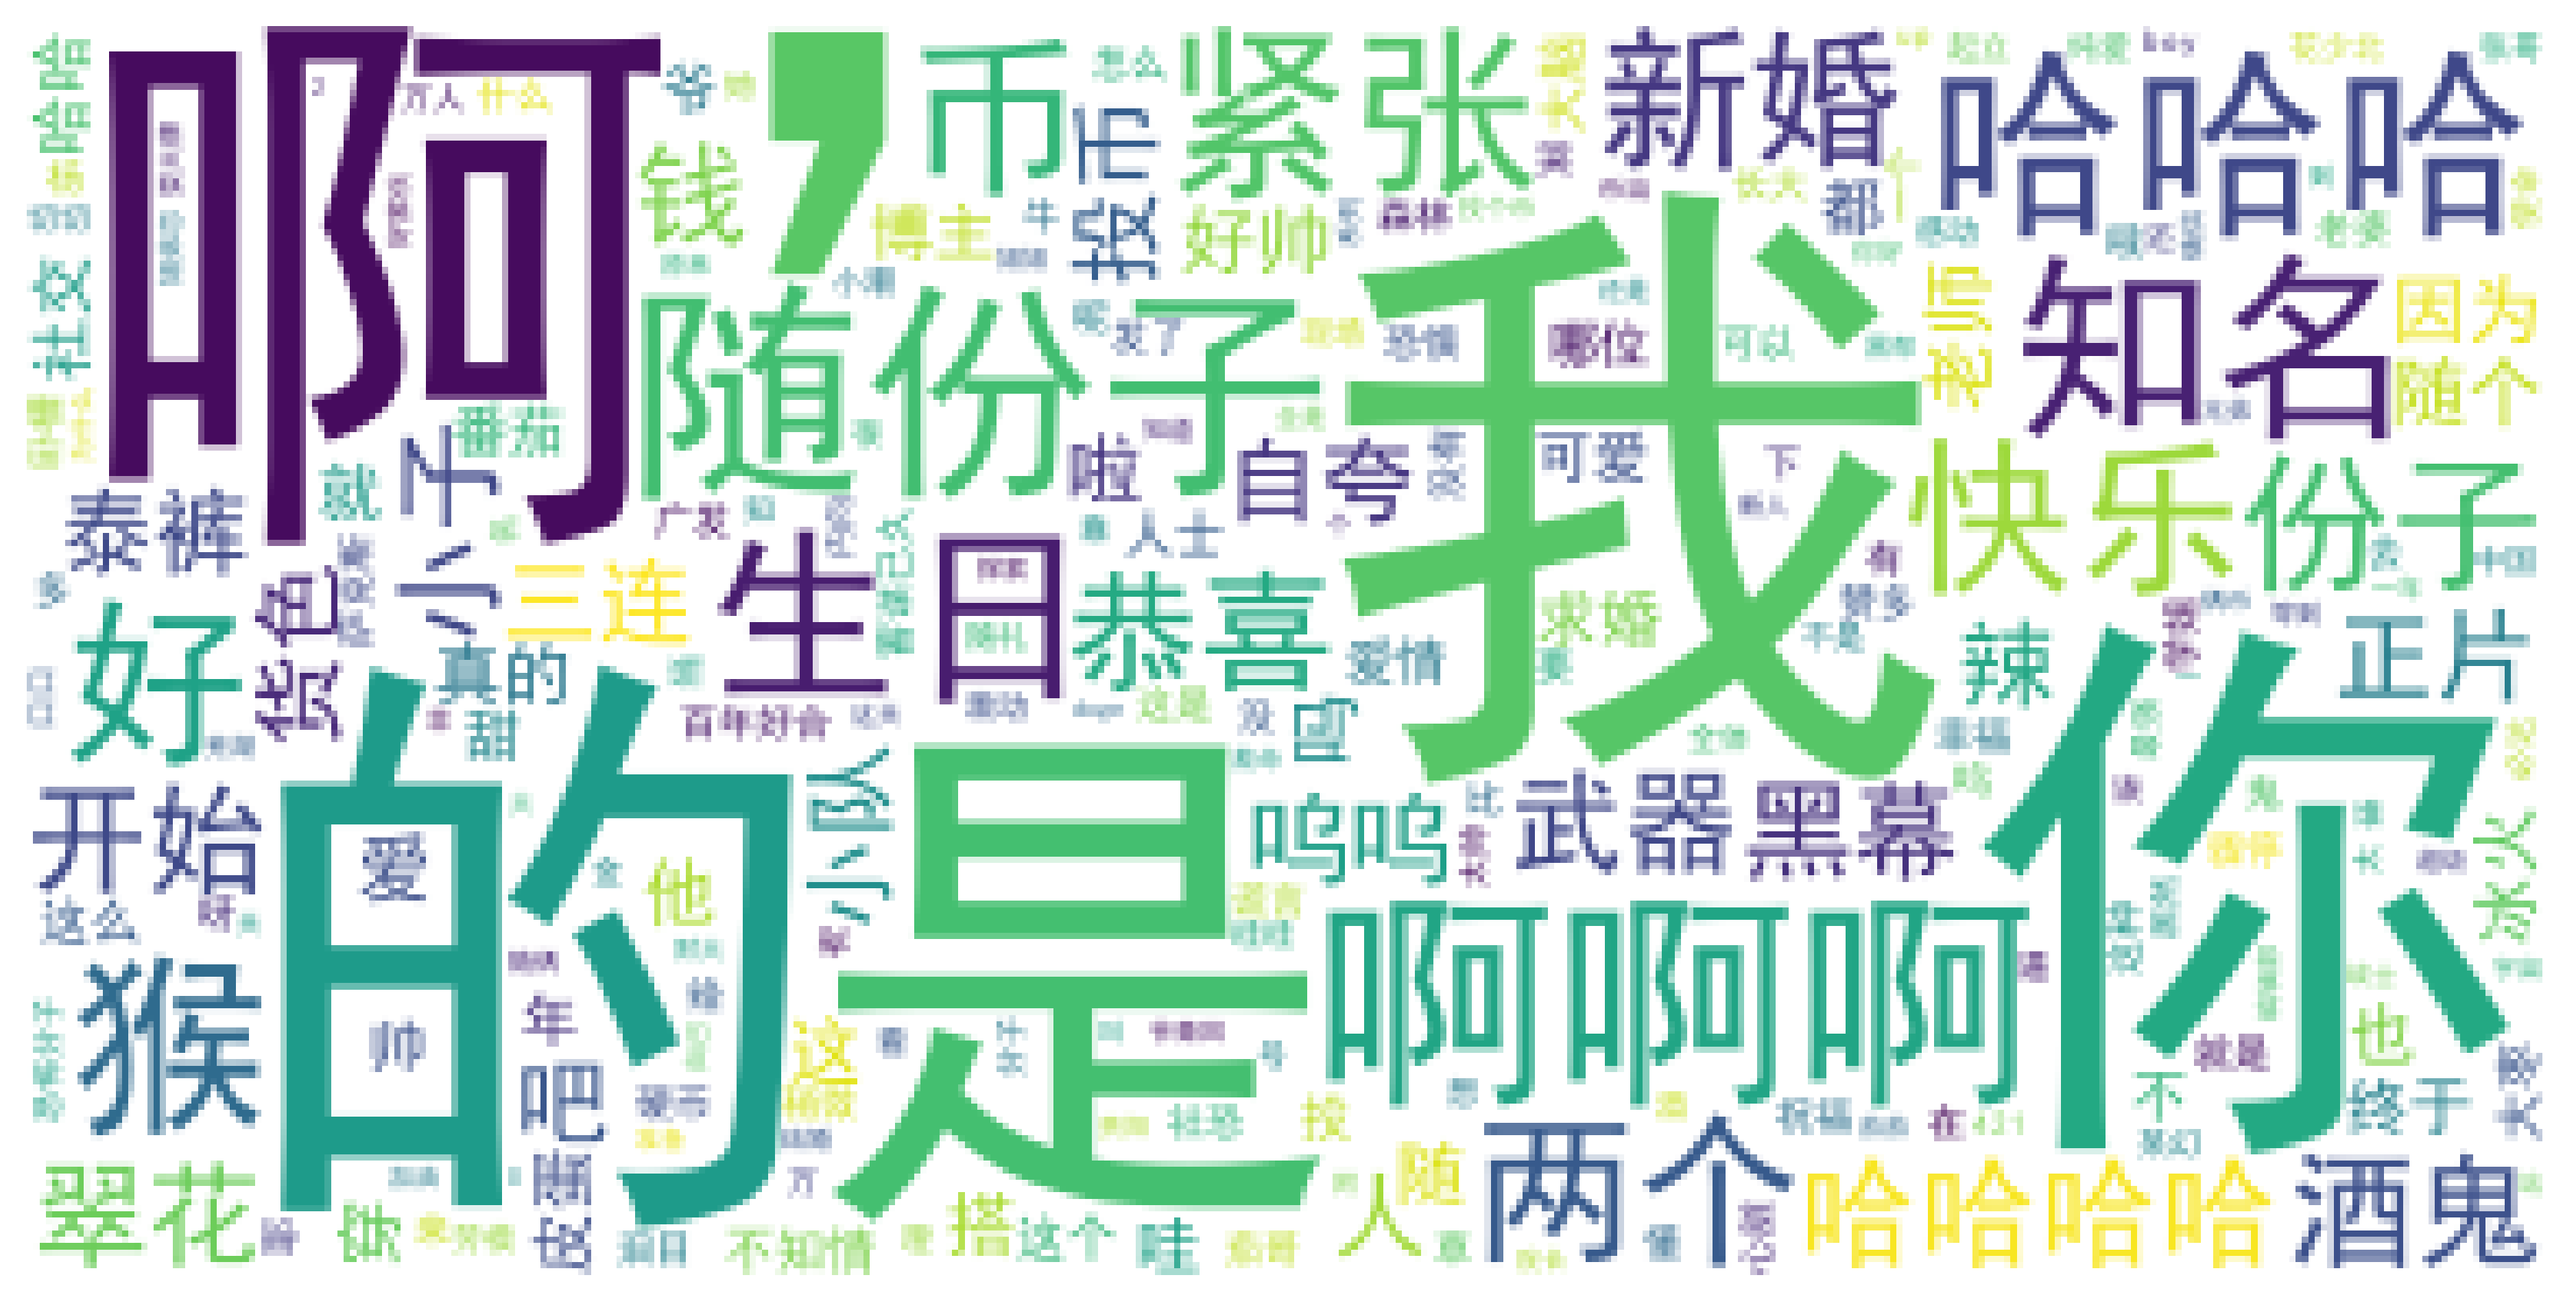

In [94]:

import warnings
warnings.filterwarnings("ignore")

# 2 读取文本文件，并使用lcut()方法进行分词
with open("video.csv",encoding="utf-8") as f:
    txt = f.read()
txt = txt.split()
data_cut = [jieba.lcut(x) for x in txt]
data_cut
# 3 读取停用词
stop = [" ","道","说道","说",'了']
# 4 去掉停用词之后的最终词
s_data_cut = pd.Series(data_cut)
all_words_after = s_data_cut.apply(lambda x:[i for i in x if i not in stop])
# 5 词频统计
all_words = []
for i in all_words_after:
    all_words.extend(i)
word_count = pd.Series(all_words).value_counts()
# 6 词云图的绘制
# 1）读取背景图片


# 2）设置词云参数
wc = WordCloud(font_path="C:/Users/Windows/fonts/simhei.ttf",
               background_color="white",
               max_words=2000,
               max_font_size=200,
               random_state=42
              )
wc2 = wc.fit_words(word_count)

# 3）绘制词云图
plt.figure(figsize=(16,8), dpi=300)
plt.imshow(wc2)
plt.axis("off")
plt.show()
wc.to_file("ciyun.jpg")

